# Tutorial

Let's load an example dataset and see how we can train, interpret and regularize a model.

In [1]:
from sklearn.datasets import load_breast_cancer

from lib.embedding_sum import EmbeddingSumClassifier


X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

Let's first create a model without regularization by setting additional losses' weights to zero

In [2]:
model_not_regularized = EmbeddingSumClassifier(
    max_bins=20,
    max_epochs=100,
    lr=10,
    step_loss_weight=0,
    embedding_sum_loss_weight=0,
    category_embedding_loss_weight=0,
)

# Basic usage

The implementation follows scikit-learn conventions, which makes it easy to integrate.

So, there are `fit` and `predict_proba` methods

In [3]:
model_not_regularized.fit(X, y)
model_not_regularized.predict_proba(X.iloc[:3])

array([[9.99474645e-01, 5.25327923e-04],
       [9.78723824e-01, 2.12761927e-02],
       [9.98975933e-01, 1.02405122e-03]])

and the `classes_` attribute

In [4]:
model_not_regularized.classes_

array([0, 1])

# Interpretability

Let's see how the predictions depend on the first two features.

On each plot, the bar heights (left Y axis) represent trained parameter values for feature bins and the widths correspond to number of feature values in each bin.
Model's prediction is the sum of such bin heights for each feature (plus a free term, with the sigmoid function applied to the sum).
On each border between the bars, a dot marks the cutoff feature value (right Y axis) separating corresponding bins.

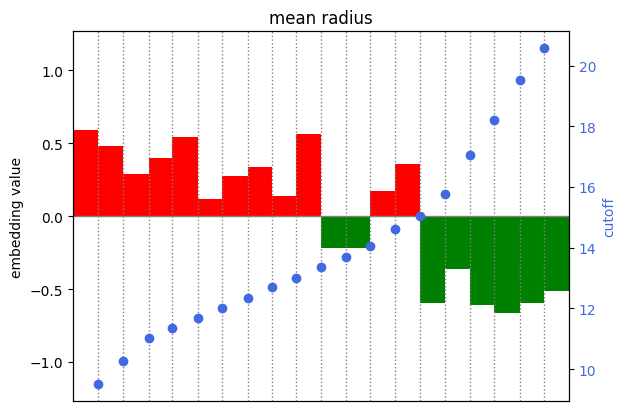

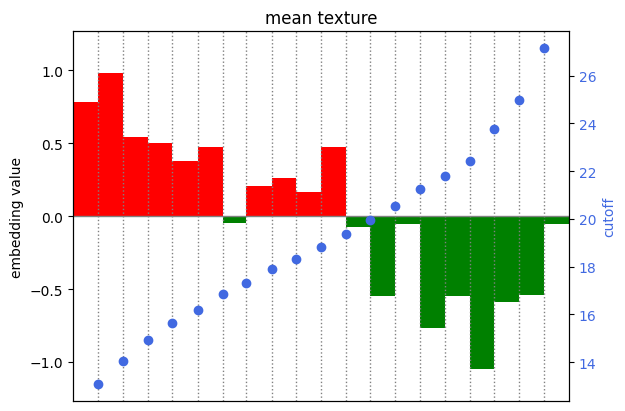

In [5]:
model_not_regularized.visualize(subset=X.columns[:2])

The second feature, "mean texture", seems to be more important.
Low values, below the cutoff at value 14, strongly indicate a positive label.
High values, especially around value 23, strongly indicate a negative label.

We can confirm that by checking feature importance values.

In [6]:
model_not_regularized.feature_importance()[['mean radius', 'mean texture']]

mean radius     0.403971
mean texture    0.452433
dtype: float32

The bars form an irregular shape that suggests overfitting and calls for regularization.

# Regularization

Now let's enable regularization

- step loss, so that consecutive bars do not differ too much
- sum loss, so that each feature's bars have a total area close to 0

In [7]:
model_regularized = EmbeddingSumClassifier(
    max_bins=20,
    max_epochs=100,
    lr=10,
    # these weights are rather large, they were chosen so that the effects are clearly visible
    step_loss_weight=5,
    embedding_sum_loss_weight=30,
    category_embedding_loss_weight=0,
).fit(X, y)

Let's check how this affected the model

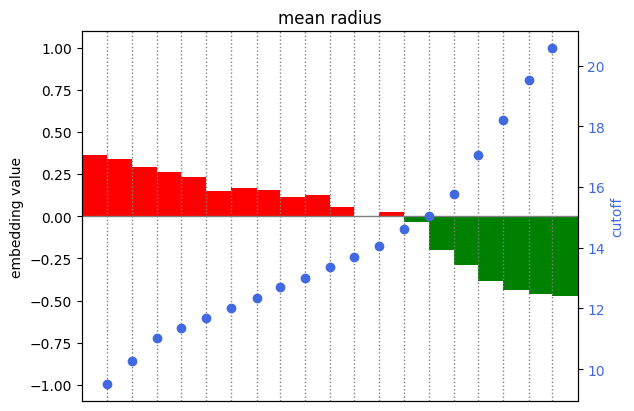

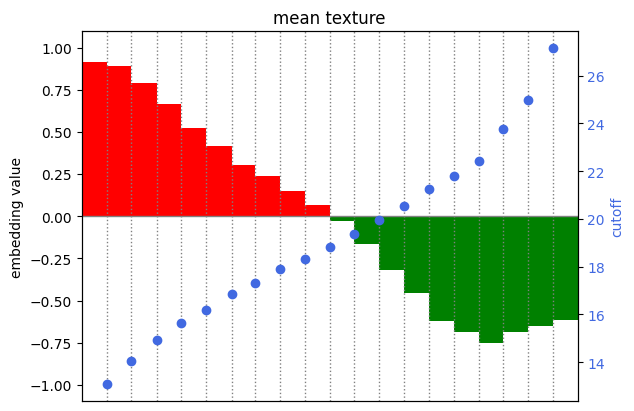

In [8]:
model_regularized.visualize(subset=X.columns[:2])

We can also check how the loss components changed during training

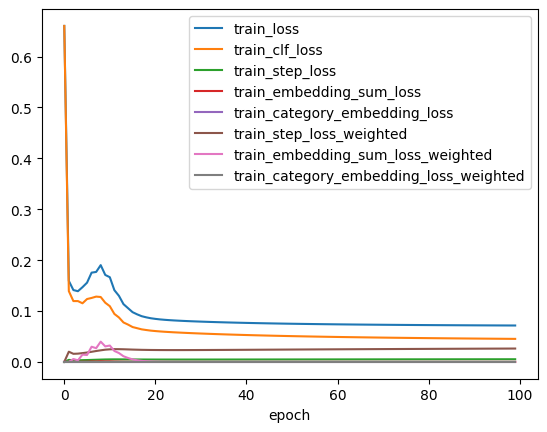

In [9]:
model_regularized.plot_training_history()

# Categorical features

Let's modify the dataset to include some categorical features and see how to handle them.

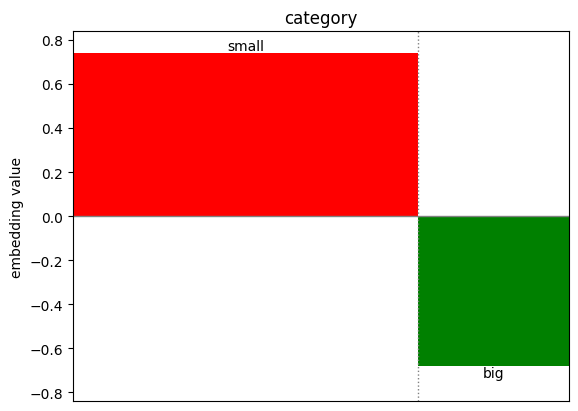

In [10]:
X_with_categorical = (
    X
    .assign(category=lambda df: (df['mean radius'] > 15))
    .drop(columns=['mean radius'])
)
model_with_categorical = EmbeddingSumClassifier(
    max_bins=20,
    max_epochs=100,
    lr=1,
    step_loss_weight=0.01,
    embedding_sum_loss_weight=0.01,
    category_embedding_loss_weight=0.01,
).fit(
    X_with_categorical, y,
    categorical_value_names={
        'category': {False: 'small', True: 'big'},
    }
)
model_with_categorical.visualize(subset=['category'])